In [2]:
import numpy as np
import pylab as plt
import glob
import h5py
# import rficnn as rfc

%matplotlib inline

In [3]:
sim_files = glob.glob('/home/gf/Downloads/temp/anke/*.h5')

class newdp(rfc.DataProvider):
    def pre_process(self, data, label):
        return np.expand_dims(data, axis=-1),np.expand_dims(label, axis=-1)

dp = newdp(files=sim_files,label_name='rfi_map')
data,rfi = dp(1)


In [21]:
# plt.imshow(rfi[0,:,:,0],aspect='auto')
# plt.imshow(data[0,:,:,0],aspect='auto')
# plt.imshow((rfi/data)[0,:,:,0],aspect='auto')


('percentage of pixels in range: ', [1, 200], 'is', 57.16599190283401)


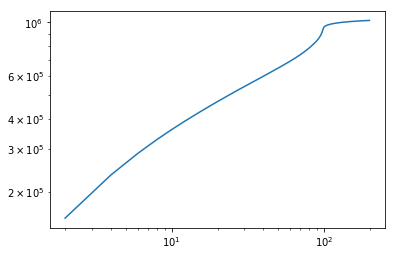

In [63]:
bins = 100

min_ratio= 1e-4
max_ratio=np.inf

rfi_ratio=abs(100*rfi/data)
rfi_accept = (min_ratio<rfi_ratio) & (rfi_ratio<max_ratio)

r2d = rfi_ratio[rfi_accept].flatten() #np.clip(.reshape(-1),0,200)

r=[1,200]
hist, bin_edges = np.histogram(r2d,bins=bins,range=r)
print( 'percentage of pixels in range: ',r,'is', 100.0*hist.sum()/float(len(r2d)) ) 
bin_cents = [0.5*(bin_edges[i]+bin_edges[i+1]) for i in range(bins)]

plt.plot(bin_cents,np.cumsum(hist))
plt.xscale('log')
plt.yscale('log')

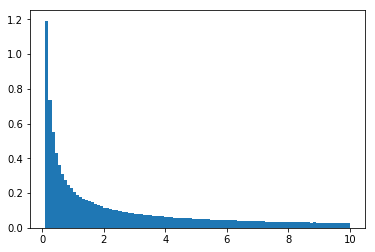

In [65]:
_=plt.hist(r2d,bins=100,range=[0.1, 10],density=True)
plt.y

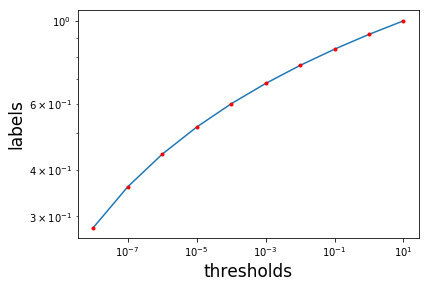

In [3]:
n_class = 10
thresholds = 10**np.linspace(-8,1,n_class,endpoint=1)
th_labels = np.linspace(0.2,1,n_class+1,endpoint=1)[1:]

plt.loglog(thresholds,th_labels)
plt.loglog(thresholds,th_labels,'r.')
plt.xlabel('thresholds',fontsize=17)
plt.ylabel('labels',fontsize=17)
plt.subplots_adjust(left=0.2, right=0.99, top=0.99, bottom=0.2)
plt.savefig('classes.jpg')

# New data provider

In [114]:
import glob 
import numpy as np
from astropy.io import fits
import h5py
from PIL import Image
from scipy.misc import toimage

'''
Created on Aug 18, 2016
original author: jakeret

Modified on: March 20, 2018
by:           yabebal fantaye

Modified on: August 28, 2018
by:	Alireza Vafaei Sadr & Anke van Dyk

'''

def to_rgb(img):
    """
    Converts the given array into a RGB image. If the number of channels is not
    3 the array is tiled such that it has 3 channels. Finally, the values are
    rescaled to [0,255) 
    
    :param img: the array to convert [nx, ny, channels]
    
    :returns img: the rgb image [nx, ny, 3]
    """
    img = np.atleast_3d(img)
    channels = img.shape[2]
    if channels < 3:
        img = np.tile(img, 3)
    
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    img *= 255
    return img

class BaseDataProvider(object):
    
    def __init__(self,files,nx,ny,
                     a_min=-np.inf, a_max=np.inf,
                     rgb=False,verbose=0,channels=1,
                     thresholds=None,th_labels=None,
                     one_hot=False):
        
        self.a_min = a_min 
        self.a_max = a_max 
        self.verbose = verbose
        self.nx = nx
        self.ny = ny
        self.rgb = rgb       
        self.files = files
        self.channels = channels
        self.thresholds = thresholds
        self.th_labels = th_labels
        if th_labels is not None:
            assert len(thresholds)==len(th_labels)-1,'Incompatibale: len(thresholds)!=len(th_labels)! /n \
            Number of thresholds have to be (threshold labels-1)!'
        if one_hot:
            self.n_class = len(thresholds)+1
        else:
            self.n_class = 1
        self.one_hot = one_hot
        assert len(files) > 0, "No training files"
        if verbose: print("Number of files used: %s"%len(files))

    def read_chunck(self): 
        filename = self.files[self.file_idx]
        data,label = np.load(filename)
        return data,label
           
    def _next_data(self):
        self.file_idx = np.random.choice(len(self.files))
        data, label = self.read_chunck()
        
        assert self.nx<=data.shape[0],'Error, Something is wrong in the given nx. Seems better to decrease it!'
        
        n_try = -1
        if self.ny>0:
            n_try += 1
            ny = data.shape[1]
            while ny < self.ny:
                print('Warning! something is wrong with {} dimensions.'.format(self.files[self.file_idx]))
                self.file_idx = np.random.choice(len(self.files))
                data, label = self.read_chunck()
                ny = data.shape[1]
                assert n_try<1000,'Error, Something is wrong in the given ny. Seems better to decrease it!'
            
        return data, label           

    def pre_process(self, data, label, one_hot):
        
        data = np.clip(np.fabs(data), self.a_min, self.a_max) # clip values that fall outside of interval of min and max
        data -= np.amin(data) # remove the min offset
        data /= np.amax(data) # scale between 0 and 1
        data = np.expand_dims(data, axis=-1) # inserting a new axis at the end of the array shape
        if self.rgb:
            data = to_rgb(data).astype(np.uint8)

        labels = threshold_mask(data=data,rfi=label,
                           thresholds=self.thresholds,
                           th_labels=self.th_labels,
                           one_hot=self.one_hot)
        return data,labels
    
    def __call__(self, n): 
        
        data, label = self._next_data()
        data, label = self.pre_process(data,label,self.one_hot)
        nx,ny,nc = data.shape   
        assert nc==self.channels,'Error, problem with given number of channel!'
        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))
        X[0] = data
        Y[0] = label
        for i in range(1,n):
            data, label = self._next_data()
            data, label = self.pre_process(data, label,self.one_hot)
            X[i] = data
            Y[i] = label
    
        return X, Y

def get_slice(data,label,nx,ny):
    """Slice matrix in x and y direction"""
    lx,ly = data.shape  
    if nx==0 or nx==lx:
        slx = slice(0, lx)                
    else:
        idx = np.random.randint(0, lx - nx)            
        slx = slice(idx, (idx+nx))       
    if ny==0 or ny==ly:
        sly = slice(0, ly)                
    else:
        idy = np.random.randint(0, ly - ny)            
        sly = slice(idy, (idy+ny))
    return data[slx, sly],label[slx, sly]
   
def read_part_chunck_hdf5(filename, label_tag):
    with h5py.File(filename, "r") as fp:
        column_names = list(fp.keys())
        if label_tag is None or not (label_tag in column_names):
            print('You did not select any label tag for mask production, please choose!',list(column_names))
            assert label_tag in column_names, 'Error, Tag is not found!'
        
        data,label = np.array(fp['data']),np.array(fp[label_tag])

    return data, label

def read_chunck_hdf5(filename,nx,ny,label_tag,verbose=0):
    """Extract data, label from hdf5 file"""
#    if thresholds is not None:
#        thresholds = thresholds
#    else:
#        thresholds = [0.01]
        
    data,label = read_part_chunck_hdf5(filename, label_tag)
    data,label = get_slice(data,label,nx,ny)
#     if label_tag=='rfi_map' and thresholds is not None:
#         label = threshold_mask(data,label,thresholds,th_labels=th_labels)
            
    return data, label

def read_part_chunck_sdfits(filename, label_tag):
    f = fits.open(filename)        
    fp = f[1].data
    column_names = fp.columns.names
    if label_tag is None or not (label_tag in column_names):
        print('You did not select any label tag for mask production, please choose!',column_names)
        assert 'Error, Tag is not found!'

    data,label = fp["DATA"].squeeze().T,fp[label_tag].squeeze().T
    f.close()
    return data, label

def read_chunck_sdfits(filename,nx,ny,label_tag,verbose=0):
    """Extract data, label from fits file"""
#    if thresholds is not None:
#        thresholds = thresholds
#    else:
#        thresholds = [0.01]
    
    data,label = read_part_chunck_sdfits(filename, label_tag)
    data,label = get_slice(data,label,nx,ny)
#     if label_tag=='RFI' and thresholds is not None:
#         label = threshold_mask(data,label,thresholds,th_labels=th_labels)
    
    return data, label

def wrangle_data(data, rfi):
    '''Prepares the data and rfi arrays for usage;
	mask negative values using a masked array and returns the percentage RFI array data
    '''
    rfi = np.ma.masked_less_equal(rfi, 0)
    data = np.ma.masked_less_equal(data, 0)
    per_rfi = 1*rfi/(data+rfi)
    #per_rfi = np.ma.fix_invalid(per_rfi)
    #per_rfi = np.ma.masked_greater(per_rfi, 90)
    return per_rfi

def threshold_mask(data,rfi,thresholds,th_labels=None,one_hot=False):
    """Returns a multi-class mask for one or list of threshold/s"""
    if not (isinstance(thresholds, list) or isinstance(thresholds, np.ndarray)):
        thresholds = [thresholds]

    n_trsh = len(thresholds)
    if th_labels is None:
        th_labels = np.arange(n_trsh+1)

    rel_rfi = wrangle_data(data[:,:,0], rfi)
    lx, ly = rel_rfi.shape
    
    if one_hot:
        mask = np.zeros((lx, ly, n_trsh+1), dtype=np.int)
        mask[:,:,0][thresholds[0]>rel_rfi] = 1
        for i in range(n_trsh-1):
            filt = (thresholds[i]<rel_rfi) & (thresholds[i+1]>=rel_rfi)
            mask[:,:,i+1][filt] = 1      
        if n_trsh>1:
            mask[:,:,-1][thresholds[n_trsh-1]<rel_rfi] = 1

    else:
        mask = np.zeros((lx, ly, 1), dtype=np.float32)
        mask[thresholds[0]>rel_rfi] = th_labels[0]
        for i in range(n_trsh-1):
            mask[(thresholds[i]<rel_rfi) & (thresholds[i+1]>=rel_rfi)] = th_labels[i+1] 
        if n_trsh>1:
            mask[thresholds[n_trsh-1]<rel_rfi] = th_labels[n_trsh]
    
    return mask

def plot_rfi_ecdf(file):
    '''Plots the Empirical Cumulative Distribution Function for all the RFI
	Able to read off the thresholds'''
    ext = file.split('.')[-1]
    if ext == 'fits':
        rfi = read_part_chunck_sdfits(file, label_tag='RFI')[1]
    elif ext == 'h5':
        rfi = read_part_chunck_hdf5(filename, label_tag)[1]
    rfi = np.array(rfi)
    rfi = np.ma.masked_less_equal(rfi, 0)
    rfi = np.ma.MaskedArray.flatten(rfi)
    count = np.ma.MaskedArray.count(rfi) # amount of data in array that have value bigger than zero
    rfi_sorted = np.ma.sort(rfi)
    y = np.arange(1, len(rfi_sorted)+1)/count
    
    import matplotlib.pyplot as plt
    plt.title('ECDF')
    plt.xlabel('RFI amplitude')
    plt.ylabel('Fraction of dataset')
    plt.xscale('log')
    plt.margins(0.02)
    plt.plot(rfi_sorted, y, marker='.', linestyle=None)
    plt.savefig('ECDF.png', format='png')
    

class DataProvider(BaseDataProvider):
    """
    CLASS DataProvider: This subclass lets you select subarrays from BaseDataProvider

    _ _ _ _

    __init__:
    |	Arguments:
    |	nx (default=0):
    |	ny (default=0): 
    |	label_name (e.g. ='rfi_map') (str): Label name
    |	thresholds (default=None) (list):
    |	th_labels (default=None) (list):
    |	a_min (default=-np.inf) (float):
    |	a_max (default=np.inf):
    |	rgb (default=False): RGB or Black and white image
    |	verbose (default=0) :
    |	channels (default=1):
    |	n_class (default=1):

    read_chunck:
    This method reads in a subset of array from BaseDataProvider class in a fits or hdf5 file
    |	Arguments:
    |		

    |	Returns:
    |		data, label

    """

    def __init__(self,files,nx=0,ny=0, 
                     label_name=None,thresholds=None,th_labels=None,
                     a_min=-np.inf, a_max=np.inf,
                     rgb=False,verbose=0,channels=1,one_hot=False):
        
        super(DataProvider, self).__init__(files, nx, ny,
                     thresholds=thresholds,th_labels=th_labels,
                     a_min=a_min, a_max=a_max,
                     rgb=rgb,verbose=verbose,channels=channels,one_hot=one_hot)
    
        self.label_tag = label_name

    def read_chunck(self):
        """Read in a subset of original data, label arrays"""
        filename = self.files[self.file_idx]
        ext = filename.split('.')[-1]
        
        nx,ny = self.nx,self.ny
        label_tag = self.label_tag
        verbose = self.verbose
        
        if ext == 'fits':
            if label_tag == 'gt_mask':
                label_tag = 'RFI_MASK'
            else:
                pass
            data,label = read_chunck_sdfits(filename,nx,ny,label_tag,verbose=verbose)
        elif ext == 'h5':
            if label_tag == 'RFI_MASK':
                label_tag = 'gt_mask'
            else:
                pass
            data,label = read_chunck_hdf5(filename,nx,ny,label_tag,verbose=verbose)
        else:
            assert 0,'Error, unsupported file format!'
            
        return data,label       
        

In [146]:
thresholds = [1e-10, 0.1]

files_list = sorted(glob.glob('../../../../works/RFI/data/hide_sims_train/calib_1year/*.fits'))
print('number of files: '+str(len(files_list)))
ws = 0

dp = DataProvider(files=files_list,label_name='RFI',
                      ny=ws,one_hot=1,
                      thresholds=thresholds,
                      a_min=0, a_max=200)
x,y = dp(1)
print(x.shape,y.shape)

dp = DataProvider(files=files_list,label_name='RFI',
                      ny=ws,
                      thresholds=thresholds,
                      a_min=0, a_max=200)
x,y2 = dp(1)
print(x.shape,y2.shape)

number of files: 2
(1, 276, 14400, 1) (1, 276, 14400, 3)
(1, 276, 14400, 1) (1, 276, 14400, 1)


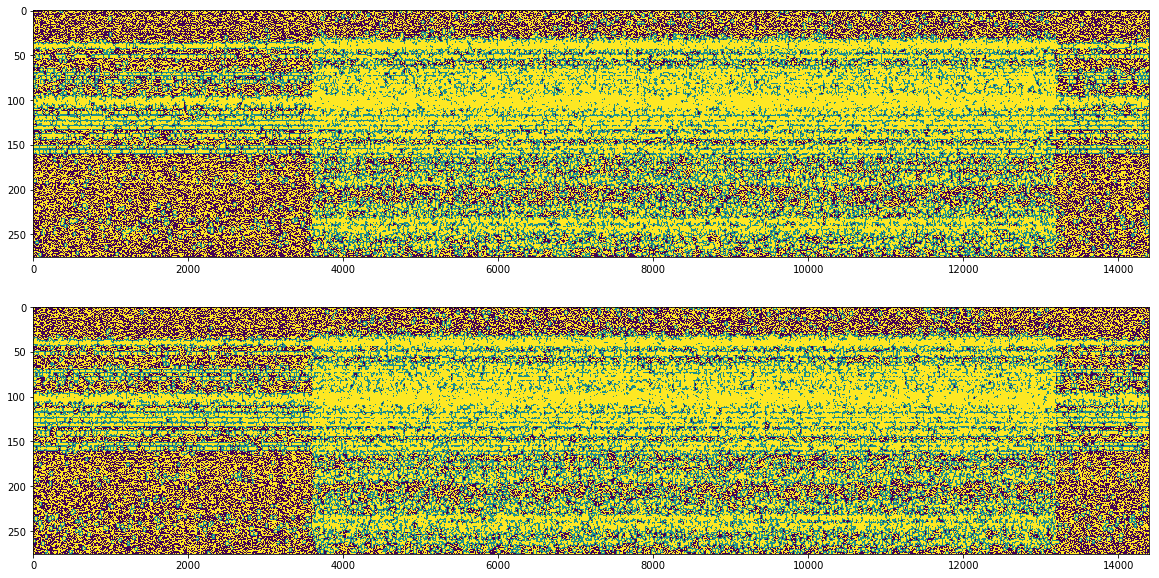

In [147]:
fig,(ax1,ax2) = plt.subplots(ncols=1,nrows=2,figsize=(20,10))

ax1.imshow(np.argmax(y[0,:,:,:],axis=2),aspect='auto')
ax2.imshow(y2[0,:,:,0],aspect='auto')

In [4]:
nx,ny = 200,200
dp = rfc.DataProvider(files=sim_files,label_name='rfi_map',
                      nx=nx,ny=ny,
                      thresholds=thresholds,
                      th_labels=th_labels,
                      a_min=0, a_max=200)

conv = rfc.ConvolutionalLayers(nx=nx,ny=ny,n_channel=1,restore=0,
                        model_add='./multiclass_model',arch_file_name='arch')

conv.train(data_provider=dp,training_epochs = 5,n_s = 10,
           learning_rate = 0.001, dropout=0.7, time_limit=None, verbose=1)